## Fetch the MNIST Dataset

In [1]:
import pickle

# from sklearn.datasets import fetch_openml
# mnist = fetch_openml("mnist_784", version=1)

# # save it to a python file
# with open("mnist_data.pkl", "wb") as f:
#     pickle.dump(mnist, f)

## Load MNIST

In [2]:
# read the mnist data
with open("mnist_data.pkl", "rb") as f:
    mnist = pickle.load(f)
    
print(mnist.keys())
X, y = mnist["data"], mnist["target"]
X.shape

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])


(70000, 784)

In [3]:
y.shape

(70000,)

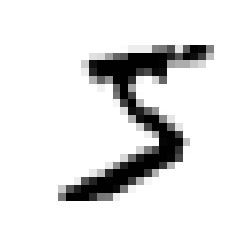

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
# label of the image above
y[0]

'5'

In [7]:
import numpy as np

# cast labels to integers
y = y.astype(np.uint8)
y[0]

5

In [8]:
# create train and test sets (mnist is already splitted as 60000:10000)
# no need to shuffle as mnist data is already shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Train a binary classifier

In [9]:
# true for all 5s, false for others
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
# in an ideal world result would be like this
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and recall

##### Precision: It's correct only %83 (precision) of the time.
##### Recall: It detects only %65 (recall) of the items.

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
from sklearn.metrics import f1_score

# harmonic mean, combining precision and recall
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Decision function (threshold) and precision/recall tradeoff

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
# return decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

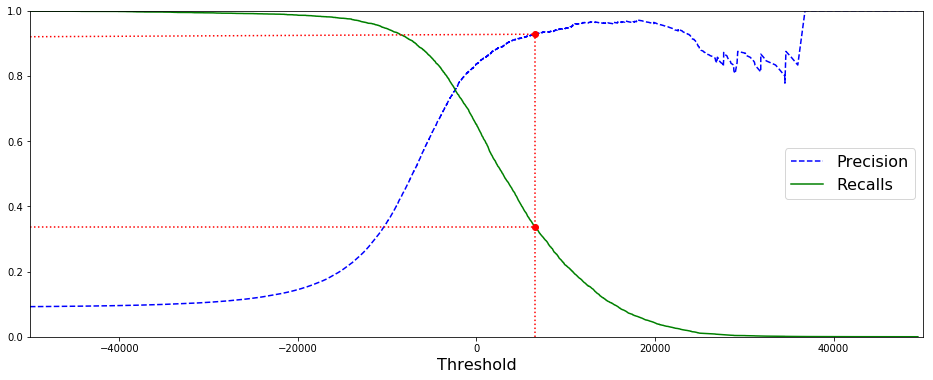

In [64]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center right", fontsize=16)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(16, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([6551, 6551], [0., 0.9277], "r:")
plt.plot([-50000, 6551], [0.92, 0.9277], "r:")
plt.plot([-50000, 6551], [0.3364, 0.3364], "r:")
plt.plot([6551], [0.9277], "ro")
plt.plot([6551], [0.3364], "ro")
plt.show()

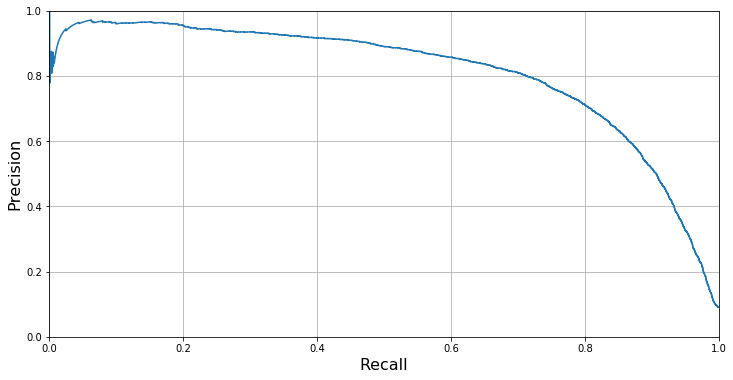

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(recalls, precisions)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)

In [75]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [76]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [77]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [78]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC curve

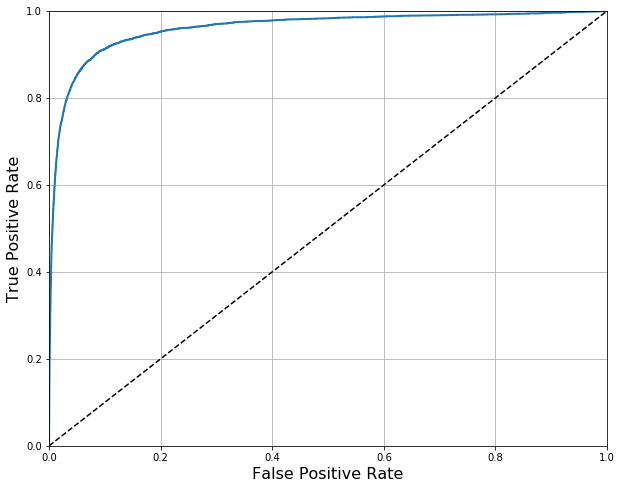

In [82]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(10, 8))
plot_roc_curve(fpr, tpr)
plt.show()

In [83]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [87]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# get the probas of positive class
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


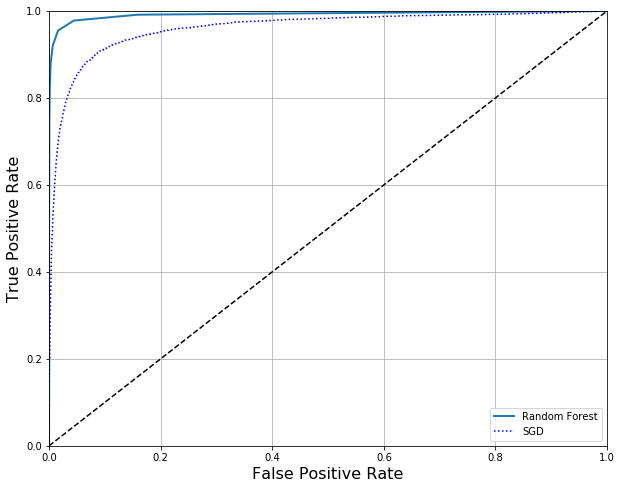

In [92]:
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
plt.show()

In [93]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [94]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.986046511627907

In [95]:
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889

## Multiclass classification

In [96]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [97]:
# let's see how many binary classifiers were trained with OvA (one-versus-all) method
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [98]:
np.argmax(some_digit_scores)

3

In [99]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [100]:
sgd_clf.classes_[3]

3

### Forcing scikit-learn to use OvO (one-versus-one)

In [101]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [102]:
len(ovo_clf.estimators_)

45

In [103]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [104]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [105]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [106]:
from sklearn.preprocessing import StandardScaler

# scaling the inputs increases accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

## Error analysis

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/burakcank/Documents/BookSolutions/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

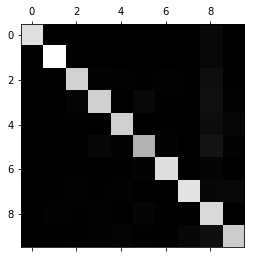

In [115]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

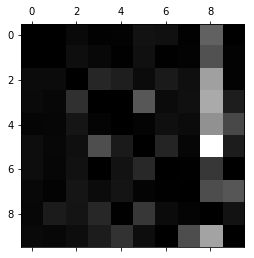

In [127]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel classification

In [221]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [222]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9671989524961443

In [227]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

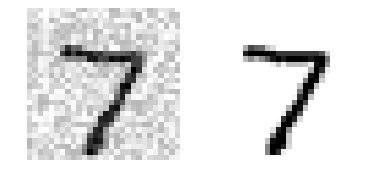

In [228]:
import os

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

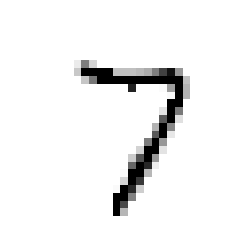

In [229]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

### 1) Trying to build a classifier with over %97 accuracy on test set

In [232]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, cv=3)

array([0.96760648, 0.96704835, 0.96754513])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        "n_neighbors": [2, 3, 4, 5, 6, 7, 8],
        "weights": ["uniform", "distance"]
    }
]

knn_gridsearch = GridSearchCV(knn, param_grid, scoring="accuracy", cv=3,
                              return_train_score=True)
knn_gridsearch.fit(X_train, y_train)

In [ ]:
knn_gridsearch.best_params_

In [ ]:
knn_gridsearch.best_estimator_

In [ ]:
knn_gridsearch.cv_results_